# Capstone Project - Sentiment Analysis of German Twitter

This notebook is supposed to take a look at the data sued for the project.

## 1. Loading the data

In [36]:
import pandas as pd
tweets_df = pd.read_csv("data/downloaded.tsv", sep="\t", header=None, names=["id", "sentiment", "md5_hash", "alternative_ids", "text"])

In [37]:
# data size
len(tweets_df.index)

9939

## 2. Preparing the data

Since the original dataset provided by the authors of the twitter sentiment corpus does only include the tweet ids. The actual tweets were loaded via the twitter api. Some of these are not available anymore, probably the authors deleted them or the accounts of the authors are deleted. We remove all tweets which are not available anymore.

In [38]:
cleaned_df = tweets_df[tweets_df['text'] != 'Not Available']
cleaned_df.head()

,id,sentiment,md5_hash,alternative_ids,text
3,367189542857482240,neutral,c020aa23ff1f8ff985ce489b2b678674,[],Tainted Talents (Ateliertagebuch.) » Wir sind ...
4,368327046574776321,neutral,0096b66e311fffcca65c23d2a310083b,[],Aber wenigstens kommt #Supernatural heute mal ...
6,368309870673793024,neutral,575fd73efa41e07e2b0c360a721d19d7,[],DARLEHEN - Angebot für Schufa-freie Darlehen: ...
7,362896018389475328,neutral,8b824c765a7642a980b9e14c02830126,[],ANRUF ERWÜNSCHT: Hardcore Teeny Vicky Carrera:...
8,367912309303148545,neutral,a07f6bc77b0cfb06a75c7cb1a88d752b,[],Na? Wo sind Frankens heimliche Talente? - Die ...


In [39]:
len(cleaned_df.index)

6539

In [40]:
positive_tweets = cleaned_df[cleaned_df['sentiment']=='positive']
neutral_tweets = cleaned_df[cleaned_df['sentiment']=='neutral']
negative_tweets = cleaned_df[cleaned_df['sentiment']=='negative']

print(f'Tweets total: {len(cleaned_df.index)}')
print(f'Positive tweets: {len(positive_tweets.index)}')
print(f'Neutral tweets: {len(neutral_tweets.index)}')
print(f'Negative tweets: {len(negative_tweets.index)}')

Tweets total: 6539
Positive tweets: 1480
Neutral tweets: 4078
Negative tweets: 981


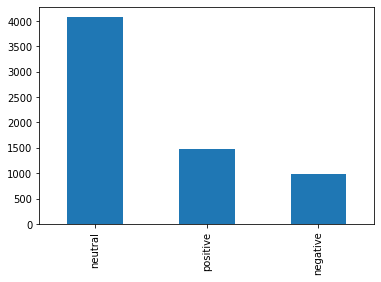

In [41]:
# plot the distribution of sentiments
ax = cleaned_df['sentiment'].value_counts().plot.bar()
fig = ax.get_figure()
fig.savefig('./figure.png', bbox_inches='tight')

In order to be able to categorize the senitments, we replace the sentiment categories which are actual words ('positive', 'neutral', negative') with numbers. We use 
- 2 for positive tweets
- 1 for neutral tweets
- 0 for negative tweets.

In [42]:
cleaned_df['sentiment'] = cleaned_df['sentiment'].apply(
      lambda x: 2 if x == 'positive' else (0 if x == 'negative' else 1))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In order to train the model in a later step, we need to divide the data into tranining and testing data. We define a method which does that for us:

In [43]:
from sklearn.model_selection import train_test_split

def splitting(df):
    X_train, X_test, y_train, y_test = train_test_split(df.text, df.sentiment, test_size=0.1, shuffle=False)
    return X_train, X_test, y_train, y_test

In [44]:
X_train, X_test, y_train, y_test = splitting(cleaned_df)

Let's take a look at the first tweets of our training data:

In [45]:
X_train.head(10)

3     Tainted Talents (Ateliertagebuch.) » Wir sind ...
4     Aber wenigstens kommt #Supernatural heute mal ...
6     DARLEHEN - Angebot für Schufa-freie Darlehen: ...
7     ANRUF ERWÜNSCHT: Hardcore Teeny Vicky Carrera:...
8     Na? Wo sind Frankens heimliche Talente? - Die ...
9                        ... Glück breitet sich aus ...
10                           @Moramee unachtsam *seufz*
11    #jobs #Sales #Medien #TV #Tele M1 sucht #Persö...
13    Happy Halloween liebe Studenten, zeigt eure gr...
14    Die App „iDelete“ hat mir 3,4 MB belegten Spei...
Name: text, dtype: object

In [57]:
X_train.iloc[8]

'Happy Halloween liebe Studenten, zeigt eure gruseligen Seiten!'

## 3. Preprocessing the data

In this part we will reduce the noise within the tweets. We will also bring the tweets in a form which is of use for machine learning algorithms. To get as much information as possible form the data set, we will make use of many Natural language Processing specific processing steps.

One step is stemming, the process of reducing words to their word stem. This is a very language specific task. There are several stemmers specifically for the German language these one perform better than general ones. Cistem has shown to be most effective for the project.

In [11]:
import nltk

#from nltk.stem.porter import PorterStemmer
#from nltk.stem.snowball import GermanStemmer
from nltk.stem.cistem import Cistem

stemmer = Cistem()

The following step is crucial for working with the tweets. We will:
- Reduce noise (remove 'rt' for retweets from the tweets)
- Unify some text elements (replace mentionings and links with a representative for that specific class)
- Tokenize sentences using a twitter sepcific tokenizer
- Stem words using the previously defined stemmer.

In [12]:
import re

nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer 

tweet_tokenizer = TweetTokenizer()

def review_to_words(text):
    text = text.lower() # Convert to lower case
    text = re.sub(r"http\S+", "XXXURLTOKENXXX", text) # replace links with token
    text = re.sub(r"@\S+", "XXXUSERNAMETOKENXXX", text) # replace mentions with token
    text = re.sub(r'[.]{2,}', ' ... ', text) # unify consecutive periods if there are at least 2
    text = re.sub("(?:(?<=^)|(?<=\s))(\d+[.,]*)+(?=$|\s)", "", text) # remove all numbers not being part of alphanumeric word
    text = re.sub(r"#", "", text) # remove '#' in front of hashtags
    text = re.sub(r"rt ", "", text) # remove 'RT'
    words = tweet_tokenizer.tokenize(text)
    words = [w for w in words if w not in stopwords.words("german")] # Remove stopwords
    words = [stemmer.stem(w) for w in words] # stem
    
    return words

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Let's see how our preprocessing step works

In [13]:
example = 'Das... ist ein.....  wunderschöner Tag! Toll!! 77.7 *seufz* <3<3 :-) @mama'
review_to_words(example)

['...',
 '...',
 'wunderscho',
 'tag',
 '!',
 'toll',
 '!',
 '!',
 '*',
 'seufz',
 '*',
 '<3',
 '<3',
 ':-)',
 'xxxusernametokenxxx']

After havind defined a routine to preprocess and split our tweets into lists of strings, we need to apply it to our datasets: 

In [14]:
def preprocess_data(data_train, data_test):
    """Convert each review to words; read from cache if available."""

    # Preprocess training and test data to obtain words for each review
    words_train = [review_to_words(review) for review in data_train]
    words_test = [review_to_words(review) for review in data_test]
    
    return words_train, words_test

In [15]:
X_train, X_test = preprocess_data(X_train, X_test)

Let's see how our data looks after this step:

In [16]:
X_train[:3]

[['tainted',
  'tal',
  '(',
  'ateliertagebuch',
  '.',
  ')',
  '»',
  'allei',
  'xxxurltokenxxx'],
 ['wenig', 'komm', 'supernatural', 'heu', 'mal', 'uhr', '-', 'schwach', 'tro'],
 ['darleh',
  '-',
  'angebo',
  'schufa-frei',
  'darleh',
  ':',
  'gunstig',
  'anbie',
  'onli',
  'darleh',
  'deutschla',
  'xxxurltokenxxx'],
 ['anruf',
  'erwunsch',
  ':',
  'hardcor',
  'teeny',
  'vicky',
  'carrera',
  ':',
  'hallo',
  'suss',
  ',',
  'jahrig',
  'vicky',
  'deutschla',
  '...',
  'xxxurltokenxxx'],
 ['na',
  '?',
  'frank',
  'heimlich',
  'tal',
  '?',
  '-',
  'ers',
  'bewerbung',
  'talentwettbewerb',
  '"',
  'wer',
  'ko',
  ',',
  'darf',
  '!',
  '"',
  '...',
  'xxxurltokenxxx'],
 ['...', 'gluck', 'brei', '...'],
 ['xxxusernametokenxxx', 'unachtsam', '*', 'seufz', '*'],
 ['job',
  'sal',
  'medie',
  'tv',
  'tel',
  'm1',
  'such',
  'personlichkei',
  'werb',
  'verkauf',
  'aussendie',
  '(',
  'm',
  '/',
  'w',
  ')',
  'xxxurltokenxxx'],
 ['happy', 'hallowee',

We can also take a look at the most frequent text elements:

In [17]:
from nltk import FreqDist

def get_all_words(cleaned_tokens_list):
    for tokens in cleaned_tokens_list:
        for token in tokens:
            yield token

all_words = get_all_words(X_train)
freq_dist = FreqDist(all_words)
print(freq_dist.most_common(50))

[('xxxusernametokenxxx', 3579), ('.', 2772), ('xxxurltokenxxx', 2757), (',', 2491), (':', 2155), ('!', 1541), ('...', 1203), ('?', 820), ('"', 711), ('-', 637), ('(', 437), (')', 408), ('*', 277), ('gut', 273), ('/', 245), ('…', 242), ('neu', 241), ('schon', 219), ('mehr', 203), ('mach', 169), ("'", 156), ('+', 150), ('dank', 150), ('mal', 147), (':)', 147), ('geh', 140), ('heu', 131), ('ie', 129), ('einfach', 119), ('gross', 115), ('bitt', 115), ('ja', 112), ('lieb', 110), ('^', 109), ('|', 107), ('klei', 101), (';)', 97), ('morg', 96), ('war', 94), ('komm', 92), ('“', 91), ('ne', 91), ('such', 87), ('ganz', 87), (':-)', 82), ('hal', 82), ('immer', 77), ('wohl', 77), ('jahr', 74), ('deutsch', 73)]


### Extract Bag-of-Words features

In [18]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.externals import joblib
# joblib is an enhanced version of pickle that is more efficient for storing NumPy arrays

def extract_features(words_train, words_test, vocabulary_size=2000):
    """Extract Bag-of-Words for a given set of documents, already preprocessed into words."""

    # Fit a vectorizer to training documents and use it to transform them
    # NOTE: Training documents have already been preprocessed and tokenized into words;
    #       pass in dummy functions to skip those steps, e.g. preprocessor=lambda x: x
    vectorizer = TfidfVectorizer(max_features=vocabulary_size, preprocessor=lambda x: x, tokenizer=lambda x: x)
    features_train = vectorizer.fit_transform(words_train).toarray()

    # Apply the same vectorizer to transform the test documents (ignore unknown words)
    features_test = vectorizer.transform(words_test).toarray()
    
    vocabulary = vectorizer.vocabulary_
    
    # Return both the extracted features as well as the vocabulary
    return features_train, features_test, vocabulary

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [19]:
# Extract Bag of Words features for both training and test datasets
X_train, X_test, vocabulary = extract_features(X_train, X_test)

In [20]:
vocabulary

{'tal': 1626,
 '(': 3,
 '.': 11,
 ')': 5,
 '»': 1973,
 'allei': 112,
 'xxxurltokenxxx': 1923,
 'wenig': 1858,
 'komm': 944,
 'heu': 770,
 'mal': 1058,
 'uhr': 1712,
 '-': 10,
 'schwach': 1475,
 'darleh': 366,
 'angebo': 128,
 ':': 48,
 'gunstig': 708,
 'anbie': 121,
 'onli': 1251,
 'deutschla': 395,
 'anruf': 133,
 'erwunsch': 529,
 'hallo': 725,
 'suss': 1617,
 ',': 9,
 'jahrig': 870,
 '...': 14,
 'na': 1150,
 '?': 71,
 'frank': 610,
 'heimlich': 752,
 'ers': 525,
 '"': 1,
 'wer': 1860,
 'darf': 364,
 '!': 0,
 'gluck': 676,
 'brei': 291,
 'xxxusernametokenxxx': 1924,
 '*': 7,
 'job': 880,
 'sal': 1416,
 'medie': 1077,
 'tv': 1699,
 'tel': 1637,
 'such': 1612,
 'verkauf': 1763,
 'm': 1044,
 '/': 15,
 'w': 1812,
 'happy': 734,
 'hallowee': 726,
 'lieb': 1019,
 'stud': 1604,
 'zeig': 1939,
 'seit': 1489,
 'app': 143,
 '„': 1980,
 '“': 1978,
 'mb': 1073,
 'speich': 1549,
 'losch': 1035,
 'bring': 293,
 'frei': 616,
 'moi': 1121,
 'check': 330,
 'out': 1265,
 'the': 1653,
 'new': 1191,
 'p

## 4. Classification

In [21]:
#X_val = pd.DataFrame(X_train[:2000])
X_train = pd.DataFrame(X_train)

#y_val = pd.DataFrame(y_train[:2000])
y_train = pd.DataFrame(y_train)

In [22]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0.00000,0.000000,0.0,0.278921,0.0,0.286094,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.129487,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.12833,0.365787,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.108985,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
y_train = y_train.reset_index(drop=True)
y_train.head()

,sentiment
0,1
1,1
2,1
3,1
4,1


In [24]:
# First we make sure that the local directory in which we'd like to store the training and validation csv files exists.
import os
data_dir = '../data/sentiment_data'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [25]:
# First, save the test data to test.csv in the data_dir directory. Note that we do not save the associated ground truth
# labels, instead we will use them later to compare with our model output.

pd.DataFrame(X_test).to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)

# Save the training and validation data to train.csv and validation.csv in the data_dir directory.
#pd.concat([y_val, X_val], axis=1).to_csv(os.path.join(data_dir, 'validation.csv'), header=False, index=False)
train_df = pd.concat([y_train, X_train], axis=1, ignore_index=True)
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000
0,1,0.00000,0.000000,0.0,0.278921,0.0,0.286094,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0.12833,0.365787,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
train_df.to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)

In [27]:
# To save a bit of memory we can set text_X, train_X, val_X, train_y and val_y to None.
#X_test = X_train = X_val = y_train = y_val = None

### Uploading Training files to S3

In [28]:
import sagemaker
import boto3

session = sagemaker.Session() # Store the current SageMaker session
bucket = session.default_bucket()

# S3 prefix (which folder will we use)
prefix = 'sentiment_data'

# deleting bucket, uncomment lines below
bucket_to_delete = boto3.resource('s3').Bucket(bucket)
bucket_to_delete.objects.all().delete()

# Upload the test.csv, train.csv and validation.csv files which are contained in data_dir to S3 using sess.upload_data().
test_location = session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)
train_location = session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)

In [29]:
empty_check = []

for obj in boto3.resource('s3').Bucket(bucket).objects.all():
    empty_check.append(obj.key)
    print(obj.key)

sentiment_data/test.csv
sentiment_data/train.csv


### Create an Estimator

In [30]:
# your import and estimator code, here
from sagemaker.sklearn.estimator import SKLearn

In [31]:
%%time

role = sagemaker.get_execution_role()
# Train your estimator on S3 training data
sklearn_estimator = SKLearn(entry_point='train.py',
                            source_dir='source_sklearn',
                            role=role,
                            train_instance_count=1,
                            train_instance_type='ml.m4.xlarge',
                            sagemaker_session=session)
sklearn_estimator.fit({'train': 's3://sagemaker-us-east-2-920979387335/sentiment_data/train.csv',
                        'test': 's3://sagemaker-us-east-2-920979387335/sentiment_data/test.csv'})

This is not the latest supported version. If you would like to use version 0.23-1, please add framework_version=0.23-1 to your constructor.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2020-08-20 09:11:08 Starting - Starting the training job...
2020-08-20 09:11:09 Starting - Launching requested ML instances......
2020-08-20 09:12:12 Starting - Preparing the instances for training...
2020-08-20 09:13:01 Downloading - Downloading input data...
2020-08-20 09:13:34 Training - Downloading the training image...
2020-08-20 09:14:04 Uploading - Uploading generated training model2020-08-20 09:13:54,760 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2020-08-20 09:13:54,763 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-08-20 09:13:54,775 sagemaker_sklearn_container.training INFO     Invoking user training script.
2020-08-20 09:13:55,046 sagemaker-containers INFO     Module train does not provide a setup.py. 
Generating setup.py
2020-08-20 09:13:55,046 sagemaker-containers INFO     Generating setup.cfg
2020-08-20 09:13:55,046 sagemaker-containers INFO     Generating MANIFEST.in
2020-08-20 09:13:55,046 sag

In [32]:
%%time

# deploy your model to create a predictor
predictor = sklearn_estimator.deploy(instance_type='ml.m4.xlarge', #'ml.p2.xlarge',
                                     initial_instance_count=1)

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-------------!CPU times: user 240 ms, sys: 17.1 ms, total: 258 ms
Wall time: 6min 31s


### Evaluating the model

In [33]:
# First: generate predicted, class labels
y_test_preds = predictor.predict(X_test)

# test that your model generates the correct number of labels
assert len(y_test_preds)==len(y_test), 'Unexpected number of predictions.'
print('Test passed!')

Test passed!


In [34]:
# Second: calculate the test accuracy
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

print('\nAccuracy:')
print(accuracy_score(y_test, y_test_preds))

print('\nF1 macro score:')
print(f1_score(y_test, y_test_preds, average='macro'))
      
print('\nClassification report:')
print(classification_report(y_test, y_test_preds))

print('\n Confusion matrix:')
print(confusion_matrix(y_test, y_test_preds, normalize='true'))


Accuracy:
0.7675840978593272

F1 macro score:
0.6403065462588965

Classification report:
              precision    recall  f1-score   support

           0       0.68      0.27      0.39        92
           1       0.78      0.92      0.85       412
           2       0.74      0.64      0.69       150

    accuracy                           0.77       654
   macro avg       0.73      0.61      0.64       654
weighted avg       0.76      0.77      0.75       654


 Confusion matrix:
[[0.27173913 0.61956522 0.10869565]
 [0.01699029 0.92475728 0.05825243]
 [0.03333333 0.32666667 0.64      ]]


In [35]:
# delete endpoint
predictor.delete_endpoint()